In [1]:

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
import rioxarray
import pandas as pd
import seaborn as sns

# Climat Dataset

In [2]:
# --- Rechargement pour une nouvelle session ---

import geopandas as gpd

# Utilisez le nom du fichier que vous avez sauvegardé
file_path = "../data/landcover_total_clean.gpkg"

# Rechargez le fichier dans une nouvelle variable
df_final_clean = gpd.read_file(file_path)

print(f"Jeu de données rechargé dans la variable 'df_final_clean' avec {df_final_clean.shape[0]} lignes.")

Jeu de données rechargé dans la variable 'df_final_clean' avec 438513 lignes.


In [3]:

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = ["precip", "tmin", "tmax"]

# Utiliser le GeoDataFrame chargé précédemment
landcover = df_final_clean
#  Boucle sur chaque variable 
for var in variables:
    
    input_dir = os.path.join(base_dir, var)
    output_dir = os.path.join(base_dir, f"{var}_alg_tun3")
    os.makedirs(output_dir, exist_ok=True)
    
    # Lister les fichiers .tif (12 mois * 5 années = 60 fichiers)
    tif_files = sorted(glob(os.path.join(input_dir, "*.tif")))
    for idx, tif_file in enumerate(tif_files, 1):
        try:
            # Charger le raster climatique
            ds = rioxarray.open_rasterio(tif_file)
            
            # Reprojeter le shapefile si besoin
            if landcover.crs != ds.rio.crs:
                landcover = landcover.to_crs(ds.rio.crs)
            
            # Découper avec le shapefile fusionné
            ds_crop = ds.rio.clip(landcover.geometry, landcover.crs)
            
            # Sauvegarder le résultat
            output_path = os.path.join(output_dir, os.path.basename(tif_file))
            ds_crop.rio.to_raster(output_path)
            
        except Exception as e:
            print(f"    [{idx}/{len(tif_files)}] Erreur sur {os.path.basename(tif_file)} : {e}")
    

# Exploration univariée et bivariée Climat Dataset


Précipitations - wc2.1_cruts4.09_5m_prec_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : 0.00 mm
   Valeur max      : 139.12 mm
   Moyenne         : 4.31 mm
   Écart-type      : 10.34 mm
   Nombre de pixels: 32927

Température Min - wc2.1_cruts4.09_5m_tmin_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : -1.50 °C
   Valeur max      : 11.00 °C
   Moyenne         : 5.67 °C
   Écart-type      : 2.11 °C
   Nombre de pixels: 32927

Température Max - wc2.1_cruts4.09_5m_tmax_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : 6.25 °C
   Valeur max      : 28.00 °C
   Moyenn

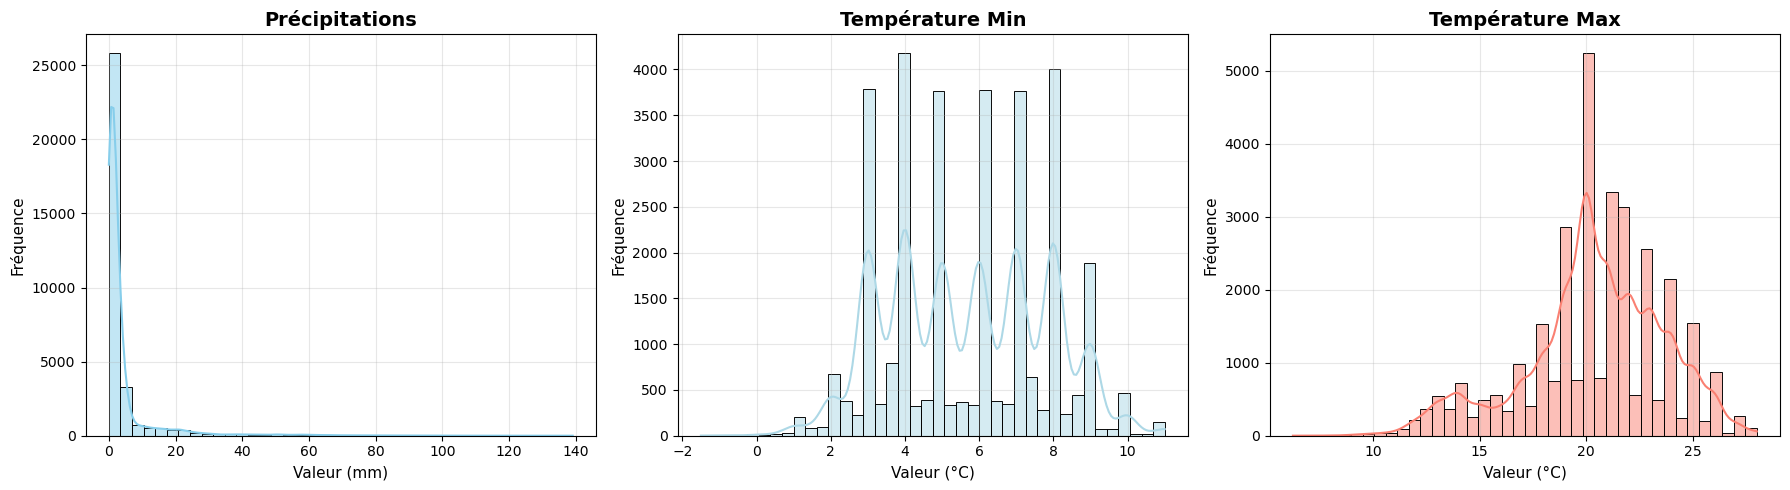

In [6]:
import numpy as np

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = {
    "precip_alg_tun": {"nom": "Précipitations", "unite": "mm", "couleur": "skyblue"},
    "tmin_alg_tun": {"nom": "Température Min", "unite": "°C", "couleur": "lightblue"},
    "tmax_alg_tun": {"nom": "Température Max", "unite": "°C", "couleur": "salmon"}
}


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (var_dir, var_info) in enumerate(variables.items()):
    raster_files = glob(os.path.join(base_dir, var_dir, "*.tif"))
    
    if len(raster_files) > 0:
        # Prendre le premier fichier comme exemple
        raster_path = raster_files[0]
        
        print(f"\n{var_info['nom']} - {os.path.basename(raster_path)}")
        print("-" * 60)
        
        with rasterio.open(raster_path) as raster:
            print(f"   Dimensions      : {raster.width} x {raster.height} pixels")
            print(f"   CRS             : {raster.crs}")
            print(f"   Résolution      : {raster.res[0]:.4f}°")
            
            data = raster.read(1).astype(float)
            
            # Nettoyer les données : supprimer nodata, NaN, et inf
            nodata_value = raster.nodata
            if nodata_value is not None:
                data = data[data != nodata_value]
            
            # Supprimer les NaN et les valeurs infinies
            data = data[~np.isnan(data)]
            data = data[~np.isinf(data)]
            
            # Aplatir le tableau pour l'analyse
            data_flat = data.flatten()
            
            if len(data_flat) > 0:
                print(f"   Valeur min      : {data_flat.min():.2f} {var_info['unite']}")
                print(f"   Valeur max      : {data_flat.max():.2f} {var_info['unite']}")
                print(f"   Moyenne         : {data_flat.mean():.2f} {var_info['unite']}")
                print(f"   Écart-type      : {data_flat.std():.2f} {var_info['unite']}")
                print(f"   Nombre de pixels: {len(data_flat)}")
            else:
                print(f"    Aucune donnée valide trouvée!")
                data_flat = np.array([0])  # Valeur par défaut pour éviter les erreurs
            
            # Histogramme
            if len(data_flat) > 0:
                sns.histplot(data_flat, bins=40, kde=True, 
                            color=var_info['couleur'], ax=axes[idx])
                axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')
                axes[idx].set_xlabel(f"Valeur ({var_info['unite']})", fontsize=11)
                axes[idx].set_ylabel("Fréquence", fontsize=11)
                axes[idx].grid(True, alpha=0.3)
            else:
                axes[idx].text(0.5, 0.5, "Pas de données valides", 
                              ha='center', va='center', fontsize=12)
                axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')
    else:
        print(f"\n Aucun fichier trouvé dans {var_dir}/")
        axes[idx].text(0.5, 0.5, f"Pas de données\n{var_info['nom']}", 
                      ha='center', va='center', fontsize=12)
        axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



Dimensions du DataFrame climatique : (10000, 3)
Statistiques descriptives :


,Précipitations,Tmin,Tmax
count,10000.000000,10000.000000,10000.000000
mean,4.520730,5.656617,20.340800
std,11.012682,2.113077,3.284683
min,0.000000,-1.500000,7.250000
25%,0.700000,4.000000,19.000000
50%,1.300000,6.000000,20.250000
75%,3.100000,7.250000,22.750000
max,123.449997,11.000000,28.000000


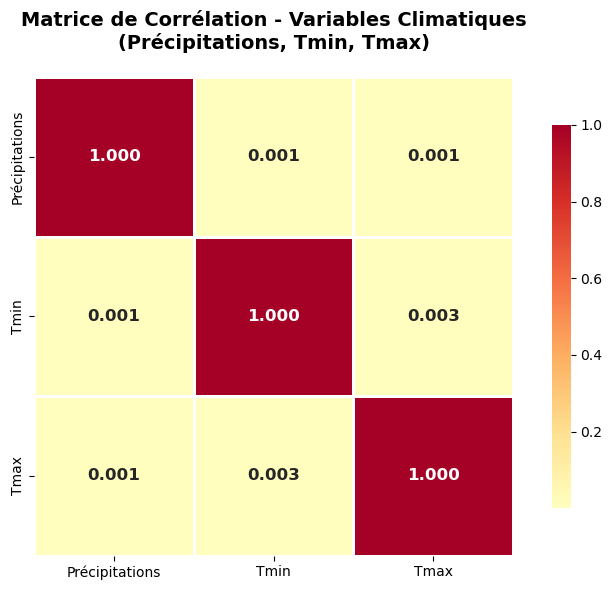

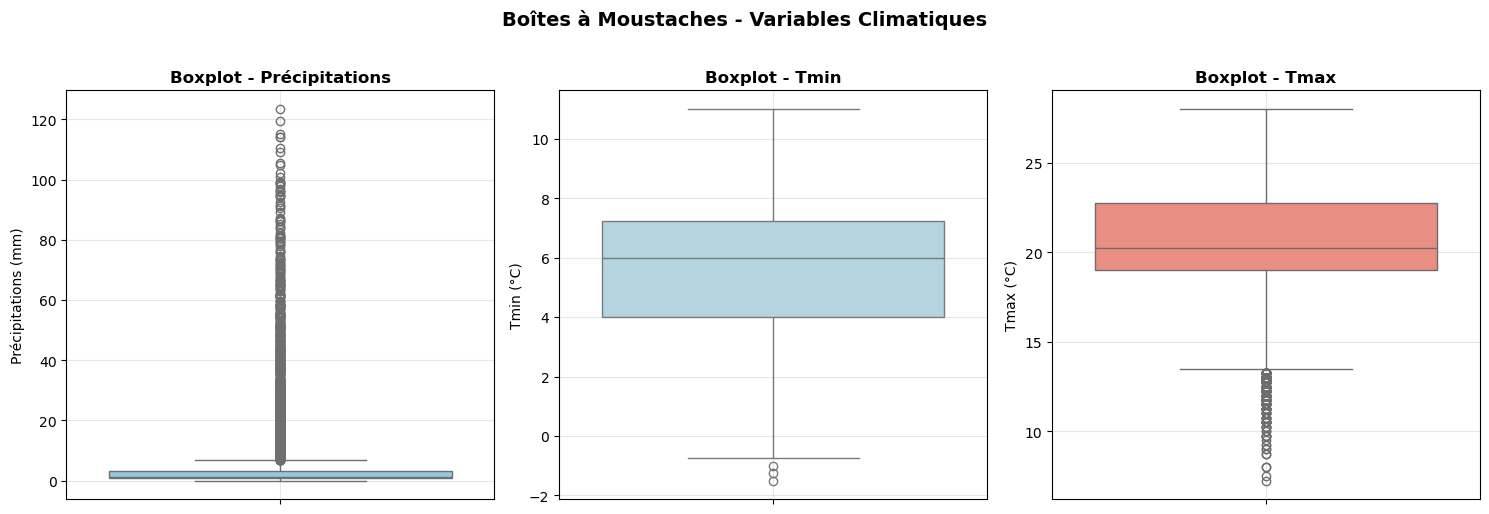

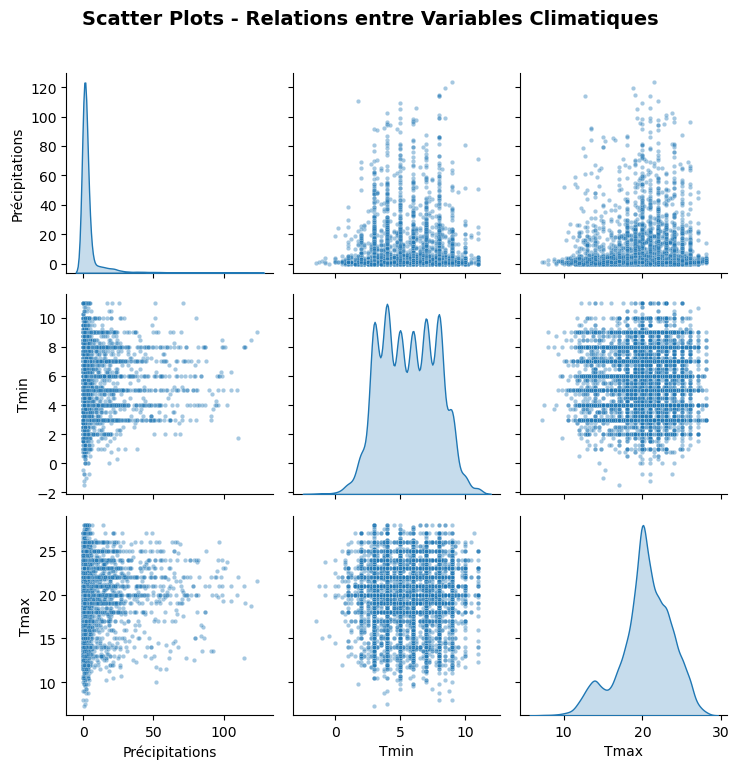

NameError: name 'stats' is not defined

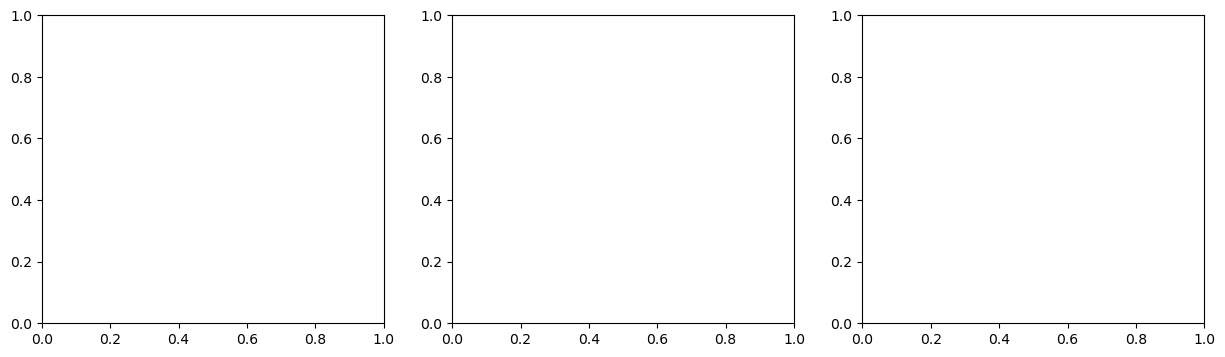

In [7]:

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = {
    "precip_alg_tun": {"nom": "Précipitations", "unite": "mm"},
    "tmin_alg_tun": {"nom": "Tmin", "unite": "°C"},
    "tmax_alg_tun": {"nom": "Tmax", "unite": "°C"}
}

# Dictionnaire pour stocker les données de chaque variable
climate_data = {}

# Charger un échantillon de données pour chaque variable
for var_dir, var_info in variables.items():
    raster_files = glob(os.path.join(base_dir, var_dir, "*.tif"))
    
    if len(raster_files) > 0:
        # Prendre le premier fichier de chaque variable
        raster_path = raster_files[0]
        
        with rasterio.open(raster_path) as raster:
            data = raster.read(1).astype(float)
            
            # Nettoyer les données
            nodata_value = raster.nodata
            if nodata_value is not None:
                data = np.where(data == nodata_value, np.nan, data)
            
            # Aplatir et nettoyer
            data_flat = data.flatten()
            data_flat = data_flat[~np.isnan(data_flat)]
            data_flat = data_flat[~np.isinf(data_flat)]
            
            # Échantillonner pour éviter trop de données (prendre 10000 points aléatoires)
            if len(data_flat) > 10000:
                sample_indices = np.random.choice(len(data_flat), 10000, replace=False)
                data_flat = data_flat[sample_indices]
            
            climate_data[var_info['nom']] = data_flat

# Créer un DataFrame avec les données climatiques
if climate_data:
    # Trouver la longueur minimale pour aligner les données
    min_length = min([len(v) for v in climate_data.values()])
    
    # Tronquer toutes les séries à la même longueur
    climate_df = pd.DataFrame({
        k: v[:min_length] for k, v in climate_data.items()
    })
    
    print(f"\nDimensions du DataFrame climatique : {climate_df.shape}")
    print(f"Statistiques descriptives :")
    display(climate_df.describe())
    
    # 1. Matrice de corrélation
    correlation_climate = climate_df.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_climate, annot=True, cmap='RdYlBu_r', 
                center=0, square=True, linewidths=2, 
                cbar_kws={"shrink": 0.8}, fmt='.3f', 
                annot_kws={"fontsize": 12, "fontweight": "bold"})
    plt.title("Matrice de Corrélation - Variables Climatiques\n(Précipitations, Tmin, Tmax)", 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # 2. Boxplots pour chaque variable climatique
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    colors = ['skyblue', 'lightblue', 'salmon']
    for idx, (col, color) in enumerate(zip(climate_df.columns, colors)):
        sns.boxplot(y=climate_df[col], ax=axes[idx], color=color)
        axes[idx].set_title(f"Boxplot - {col}", fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(f"{col} ({list(variables.values())[idx]['unite']})", fontsize=10)
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle("Boîtes à Moustaches - Variables Climatiques", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
   
    # 3. Scatter plots 
    sns.pairplot(climate_df, diag_kind='kde', plot_kws={'alpha': 0.4, 's': 10})
    plt.suptitle("Scatter Plots - Relations entre Variables Climatiques", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 4. Q-Q Plots 
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, col in enumerate(climate_df.columns):
        stats.probplot(climate_df[col], dist="norm", plot=axes[idx])
        axes[idx].set_title(f"Q-Q Plot - {col}", fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle("Q-Q Plots - Test de Normalité (Variables Climatiques)", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 5. Scatter plots individuels avec ligne de régression
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    pairs = [
        ('Précipitations', 'Tmin'),
        ('Précipitations', 'Tmax'),
        ('Tmin', 'Tmax')
    ]
    
    for idx, (var1, var2) in enumerate(pairs):
        if var1 in climate_df.columns and var2 in climate_df.columns:
            sns.regplot(x=climate_df[var1], y=climate_df[var2], 
                       ax=axes[idx], scatter_kws={'alpha': 0.3, 's': 10},
                       line_kws={'color': 'red', 'linewidth': 2})
            axes[idx].set_xlabel(var1, fontsize=10, fontweight='bold')
            axes[idx].set_ylabel(var2, fontsize=10, fontweight='bold')
            axes[idx].set_title(f"{var1} vs {var2}", fontsize=12, fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
            
            # Ajouter le coefficient de corrélation
            corr = climate_df[var1].corr(climate_df[var2])
            axes[idx].text(0.05, 0.95, f'r = {corr:.3f}', 
                          transform=axes[idx].transAxes,
                          fontsize=11, fontweight='bold',
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle("Scatter Plots avec Régression Linéaire", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
